# Backtesting with backtrader library
Notes:  
Timestamp must be in the exact format specified for datafeed   **Timestamp needs to be first column index**  
Params for datafeed need to be specified as tuple of tuples  
Within strategy data is accessed via self.datas[0] for ex: self.datas[0].high_delta[0] would get you the first timeperiod's high_delta  
The current data has already happened and cannot be used to execute an order (ex. you cannot look at the current close price and simultaneously buy the current close, the order will be executed at open instead), orders will be executed on the following day.

In [1]:
import backtrader as bt
import datetime
import pandas as pd

## Define Strategies and Data utils

In [2]:
class BasicStrategy(bt.Strategy):
    def __init__(self):
        # To keep track of pending orders
        self.order = None
        
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

#         elif order.status in [order.Canceled, order.Margin, order.Rejected]:
#             self.log('Order Canceled/Margin/Rejected')
    

    def next(self):
        # STRATEGY 
        data = self.datas[0]
        self.log(f'Current Portfolio Value : {self.broker.get_value()}')
        #self.log('Close, %.2f' % data.close[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            self.log('ORDER CANCELLED')
            self.cancel(self.order)
        
        # Check if we are in the market
        if not self.position:
            # BUY
            try:
                self.size = int(self.broker.get_cash() / self.datas[0].open[1])
            except:
                print('Size Exception')
            # invest if prediction looks good
            if (data.prediction[0] >= data.close[0]):
                 
                self.log(f'BUY CREATE {self.size} shares at {data.close[0]}')
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=self.size) # market order buys at next open
                
        else:
            # place sell order at predicted high if predicted high is greater than current close price
            if data.prediction[0] > data.close:
                self.log(f'SELL CREATE {self.size} shares at {data.prediction[0]}')
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(exectype=bt.Order.Limit,
                             price=data.prediction[0],
                             valid=data.datetime.date(0) + datetime.timedelta(days=2),
                             size=self.size)
            # if prediction is less than current value sell at open
            else:
                self.log('MARKET SELL CREATE. PREDICTION < CURRENT CLOSE')
                self.order = self.sell(size=self.size)
        

In [3]:
class BuyAndHold(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

#         elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash() / self.datas[0].open[1])
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print(f'Stop price: {self.datas[0].close[0]}')
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

In [4]:
def prepare_data(data, fromdate, todate, filepath):
    """Prepare data for backtrader datafeed object
        Returns prepared data filepath and params for the GenericCSVData class, also returns columns used"""
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    # start param setup for backtrader
    start = data['timestamp'].iloc[0]
    end = data['timestamp'].iloc[-1]
    from_to = [(start.year, start.month, start.day), (end.year, end.month, end.day)]
    # Backtrader string format
    data['timestamp'] = data['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    # backtrader data feed class needs a file path, this could be a temp file that's constantly overwritten
    data.to_csv(filepath)
    
    starting_params = [
    ('fromdate', datetime.datetime(*from_to[0])),
    ('todate', datetime.datetime(*from_to[1])),
    ('nullvalue', 0.0),
    ('dtformat', ('%Y-%m-%d %H:%M:%S')),
    ('tmformat', ('%H:%M:%S')),
    ('datetime', 1)]
    # skip nonfeatures (timestamp)
    cols = data.columns[1:]
    # get column position for each indicator and add to starting params list
    i = 2 # starting index since others are reserved
    for indicator in cols:
        starting_params.append((indicator, i))
        i+=1
    final_params = tuple(starting_params)

    return filepath, final_params, cols 


## Import Data and Run Backtest

In [5]:
import os

In [6]:
def capstone_data_prep(pred_folder_name, pred_col_name, ticker_df_filepath, starting_cash=100000):
    """Main loop, preps data and executes backtrader on all stocks in the prediction folder"""
    ticker_backtesting_dict = {}
    for pred_file in os.listdir(f'../data/ticker_predictions/{pred_folder_name}'):
        ticker_name = pred_file.split('_')[0]
        pred_df = pd.read_csv(f'../data/ticker_predictions/{pred_folder_name}/{pred_file}')
        ticker_df = pd.read_csv(ticker_df_filepath + f'/{ticker_name}_full_data.csv')
        # new prediction column name = "prediction", important because backtester strategy looks for this column name
        ticker_df['prediction'] = pred_df[pred_col_name]
        # remove all non-prediction rows, use "timestamp" as the common datetime name
        ticker_df = ticker_df[ticker_df.prediction > 0]
        ticker_df = ticker_df.rename({'reportperiod':'timestamp'}, axis=1)

        # make timestamp in column position 0 
        ticker_cols = list(ticker_df.columns)
        ticker_cols[5] = 'ts_cpy'
        ticker_cols[0] = 'timestamp'
        ticker_df.columns = ticker_cols
        ticker_df['timestamp'] = ticker_df['ts_cpy']

        # skip nonfeatures, keep timestamp
        nonfeatures = ticker_df.columns[1:7]
        features = [col for col in ticker_df.columns if col not in nonfeatures]
        # get index of start and end dates for trading
        ticker_df = ticker_df[features]
        ticker_df.columns = [c.lower() for c in ticker_df.columns]
        idx1 = ticker_df.prediction[ticker_df.prediction > 0].index[0]
        idx2 = ticker_df.prediction[ticker_df.prediction > 0].index[-1]
        start_date = pred_df.timestamp[idx1]
        end_date  = pred_df.timestamp[idx2]

        # Prepare data for backtrader
        prep_data = prepare_data(ticker_df.copy(), start_date, end_date, 'temp/prep_data.csv')
        class DataFeed(bt.feeds.GenericCSVData):
            lines = tuple(prep_data[2])
            params = prep_data[1]
        
        print(f"--------Ticker Name-------: {ticker_name}")
        ##### BUY AND HOLD #######
        print('BUY AND HOLD')
        # initialize everything and run strategy
        cerebro = bt.Cerebro(cheat_on_open=True)
        cerebro.broker.setcash(starting_cash)
        #cerebro.addsizer(bt.sizers.FixedSize, stake=10)
        print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')
        data = DataFeed(dataname=prep_data[0])
        cerebro.adddata(data)
        cerebro.addstrategy(BuyAndHold)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Months, _name = 'sharpe')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'dd')
        cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
        buy_hold = cerebro.run()
        buy_hold_ret = cerebro.broker.getvalue() / starting_cash - 1
        print(f'Final Portfolio Value: {cerebro.broker.getvalue()}\n')
        print('STRATEGY INFO:')
        print(buy_hold[0].analyzers.sharpe.get_analysis())
        print(buy_hold[0].analyzers.dd.get_analysis())
        # rtot is total log returns over the strategy time period
        print(buy_hold[0].analyzers.returns.get_analysis())

        #### MAIN STRATEGY #####
        cerebro = bt.Cerebro(cheat_on_open=True)
        cerebro.broker.setcash(starting_cash)
        print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')
        data = DataFeed(dataname=prep_data[0])
        cerebro.adddata(data)
        cerebro.addstrategy(BasicStrategy)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Months, _name = 'sharpe')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'dd')
        cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
        back = cerebro.run()
        strat_ret = cerebro.broker.getvalue() / starting_cash - 1
        print(f'Final Portfolio Value: {cerebro.broker.getvalue()}\n')
        print('STRATEGY INFO:')
        print(back[0].analyzers.sharpe.get_analysis())
        print(back[0].analyzers.dd.get_analysis())
        # rtot is total log returns over the strategy time period
        print(back[0].analyzers.returns.get_analysis())
        print(f"For {ticker_name}, return was {buy_hold_ret*100}% for buy and hold vs {strat_ret*100}%  for strategy")
        print('\n'*5)

        ticker_backtesting_dict[ticker_name] = cerebro
        
    return ticker_backtesting_dict

In [7]:
cerebro_dict = capstone_data_prep('xgboost_preds', 'holdout_preds', '../data/ticker_data')

--------Ticker Name-------: ADSK
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-18, BUY EXECUTED, 152.13
Stop price: 324.5199890136719
ROI:        113.26%
Final Portfolio Value: 213260.2195739746

STRATEGY INFO:
OrderedDict([('sharperatio', 0.34389316593937563)])
AutoOrderedDict([('len', 51), ('drawdown', 5.184798097797453), ('moneydown', 11661.75), ('max', AutoOrderedDict([('len', 136), ('drawdown', 35.45867074864162), ('moneydown', 49117.31639099124)]))])
OrderedDict([('rtot', 0.7573429222083454), ('ravg', 0.0013998944957640397), ('rnorm', 0.423008671539144), ('rnorm100', 42.3008671539144)])
Starting Portfolio Value: 100000
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, BUY CREATE 657 shares at 153.6699981689453
2019-09-18, BUY EXECUTED, 152.13
2019-09-18, Current Portfolio Value : 99329.85719299316
2019-09-18, ORDER CANCELLED
2019-09-18, SELL CREATE 657 shares at 153.13153582674204
2019-09-19, SELL EXECUTED, 153.13
2019-09-19, Current Portfolio Value : 100658.0058

2020-07-07, Current Portfolio Value : 165598.82764548092
2020-07-07, ORDER CANCELLED
2020-07-07, SELL CREATE 693 shares at 242.09077397704826
2020-07-08, SELL EXECUTED, 242.09
2020-07-08, Current Portfolio Value : 167782.31231968084
2020-07-08, ORDER CANCELLED
2020-07-08, BUY CREATE 670 shares at 243.8999938964844
2020-07-09, BUY EXECUTED, 250.30
2020-07-09, Current Portfolio Value : 166375.30823032538
2020-07-09, ORDER CANCELLED
2020-07-09, SELL CREATE 670 shares at 251.45402758888852
2020-07-10, Current Portfolio Value : 163722.11395542306
2020-07-10, ORDER CANCELLED
2020-07-10, SELL CREATE 670 shares at 247.4421185927549
2020-07-13, Current Portfolio Value : 155427.5106839387
2020-07-13, ORDER CANCELLED
2020-07-13, SELL CREATE 670 shares at 235.14345084577874
2020-07-14, Current Portfolio Value : 157263.31436435855
2020-07-14, ORDER CANCELLED
2020-07-14, SELL CREATE 670 shares at 237.71125126826882
2020-07-15, Current Portfolio Value : 157919.91150180975
2020-07-15, ORDER CANCELLED


2021-03-23, SELL EXECUTED, 269.85
2021-03-23, Current Portfolio Value : 148356.69875687204
2021-03-23, ORDER CANCELLED
2021-03-23, BUY CREATE 549 shares at 269.0
2021-03-24, BUY EXECUTED, 270.00
2021-03-24, Current Portfolio Value : 144612.51473587594
2021-03-24, ORDER CANCELLED
2021-03-24, SELL CREATE 549 shares at 267.0271053602555
2021-03-25, Current Portfolio Value : 144069.01009720407
2021-03-25, ORDER CANCELLED
2021-03-25, SELL CREATE 549 shares at 266.022643645927
2021-03-26, SELL EXECUTED, 266.02
2021-03-26, Current Portfolio Value : 146173.13011848598
2021-03-26, ORDER CANCELLED
2021-03-26, BUY CREATE 547 shares at 269.010009765625
2021-03-29, BUY EXECUTED, 266.97
2021-03-29, Current Portfolio Value : 148257.19878303682
2021-03-29, ORDER CANCELLED
2021-03-29, SELL CREATE 547 shares at 274.7382068384068
2021-03-30, Current Portfolio Value : 146971.74544441374
2021-03-30, ORDER CANCELLED
2021-03-30, SELL CREATE 547 shares at 272.3538488139966
2021-03-31, SELL EXECUTED, 272.35
20

--------Ticker Name-------: HD
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-18, BUY EXECUTED, 230.37
Stop price: 368.3999938964844
ROI:        59.91%
Final Portfolio Value: 159905.01947021484

STRATEGY INFO:
OrderedDict([('sharperatio', 0.2678087736341331)])
AutoOrderedDict([('len', 7), ('drawdown', 1.0527348079031698), ('moneydown', 1701.2858276367479), ('max', AutoOrderedDict([('len', 143), ('drawdown', 38.398844103663656), ('moneydown', 41173.58450317381)]))])
OrderedDict([('rtot', 0.46940982466753095), ('ravg', 0.0008676706555776913), ('rnorm', 0.24439940164811577), ('rnorm100', 24.439940164811578)])
Starting Portfolio Value: 100000
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, BUY CREATE 434 shares at 230.2100067138672
2019-09-18, BUY EXECUTED, 230.37
2019-09-18, Current Portfolio Value : 100199.64291381836
2019-09-18, ORDER CANCELLED
2019-09-18, SELL CREATE 434 shares at 232.73308312018344
2019-09-19, Current Portfolio Value : 99023.5
2019-09-19, ORDER CANCE

2020-06-09, ORDER CANCELLED
2020-06-09, SELL CREATE 442 shares at 258.8768713802565
2020-06-10, SELL EXECUTED, 258.88
2020-06-10, Current Portfolio Value : 114458.30741827496
2020-06-10, ORDER CANCELLED
2020-06-10, BUY CREATE 459 shares at 254.4499969482422
2020-06-11, BUY EXECUTED, 248.86
2020-06-11, Current Portfolio Value : 110148.29769842631
2020-06-11, ORDER CANCELLED
2020-06-11, SELL CREATE 459 shares at 241.56044450394984
2020-06-12, SELL EXECUTED, 243.07
2020-06-12, Current Portfolio Value : 111800.70049993998
2020-06-12, ORDER CANCELLED
2020-06-12, BUY CREATE 470 shares at 242.4499969482422
2020-06-15, BUY EXECUTED, 237.62
2020-06-15, Current Portfolio Value : 113558.5030817271
2020-06-15, ORDER CANCELLED
2020-06-15, SELL CREATE 470 shares at 243.34989662673615
2020-06-16, SELL EXECUTED, 249.40
2020-06-16, Current Portfolio Value : 117337.29992620953
2020-06-16, ORDER CANCELLED
2020-06-16, BUY CREATE 464 shares at 249.9499969482422
2020-06-17, BUY EXECUTED, 252.77
2020-06-17, 

2021-02-24, Current Portfolio Value : 115706.29544111606
2021-02-24, ORDER CANCELLED
2021-02-24, SELL CREATE 445 shares at 262.23939838998194
2021-02-25, Current Portfolio Value : 113605.8948979032
2021-02-25, ORDER CANCELLED
2021-02-25, SELL CREATE 445 shares at 257.8000633120537
2021-02-26, SELL EXECUTED, 257.80
2021-02-26, Current Portfolio Value : 114740.67307176709
2021-02-26, ORDER CANCELLED
2021-02-26, BUY CREATE 443 shares at 258.33999633789057
2021-03-01, BUY EXECUTED, 258.81
2021-03-01, Current Portfolio Value : 115985.50199022415
2021-03-01, ORDER CANCELLED
2021-03-01, SELL CREATE 443 shares at 264.1066707456921
2021-03-02, Current Portfolio Value : 115396.3179387105
2021-03-02, ORDER CANCELLED
2021-03-02, SELL CREATE 443 shares at 262.7640427650586
2021-03-03, Current Portfolio Value : 114098.31766405227
2021-03-03, ORDER CANCELLED
2021-03-03, SELL CREATE 443 shares at 259.8061699523969
2021-03-04, Current Portfolio Value : 111249.83090868118
2021-03-04, ORDER CANCELLED
202

2021-10-14, Current Portfolio Value : 151126.6573587328
2021-10-14, ORDER CANCELLED
2021-10-14, BUY CREATE 436 shares at 344.04998779296875
2021-10-15, BUY EXECUTED, 346.54
2021-10-15, Current Portfolio Value : 152813.97522982655
2021-10-15, ORDER CANCELLED
2021-10-15, SELL CREATE 436 shares at 353.2989640060987
2021-10-18, Current Portfolio Value : 154819.57789095936
2021-10-18, ORDER CANCELLED
2021-10-18, SELL CREATE 436 shares at 357.93689492647536
2021-10-19, SELL EXECUTED, 357.94
2021-10-19, Current Portfolio Value : 156095.69982109012
2021-10-19, ORDER CANCELLED
2021-10-19, BUY CREATE 436 shares at 357.989990234375
2021-10-20, BUY EXECUTED, 357.74
2021-10-20, Current Portfolio Value : 156309.34886894168
2021-10-20, ORDER CANCELLED
2021-10-20, SELL CREATE 436 shares at 361.18344349382096
2021-10-21, SELL EXECUTED, 361.18
2021-10-21, Current Portfolio Value : 157597.04544220856
2021-10-21, ORDER CANCELLED
2021-10-21, BUY CREATE 431 shares at 364.6199951171875
2021-10-22, BUY EXECUT

2020-07-02, ORDER CANCELLED
2020-07-02, BUY CREATE 758 shares at 206.25999450683597
2020-07-06, BUY EXECUTED, 208.83
2020-07-06, Current Portfolio Value : 159848.26737002516
2020-07-06, ORDER CANCELLED
2020-07-06, SELL CREATE 758 shares at 212.318160128998
2020-07-07, SELL EXECUTED, 212.32
2020-07-07, Current Portfolio Value : 161074.83506103806
2020-07-07, ORDER CANCELLED
2020-07-07, BUY CREATE 766 shares at 208.25
2020-07-08, BUY EXECUTED, 210.07
2020-07-08, Current Portfolio Value : 163188.9908532744
2020-07-08, ORDER CANCELLED
2020-07-08, SELL CREATE 766 shares at 214.46452331995533
2020-07-09, SELL EXECUTED, 216.33
2020-07-09, Current Portfolio Value : 165869.9908532744
2020-07-09, ORDER CANCELLED
2020-07-09, BUY CREATE 776 shares at 214.32000732421875
2020-07-10, BUY EXECUTED, 213.62
2020-07-10, Current Portfolio Value : 165908.79322143845
2020-07-10, ORDER CANCELLED
2020-07-10, SELL CREATE 776 shares at 215.310970778708
2020-07-13, Current Portfolio Value : 160787.20032593064
20

2021-03-11, SELL EXECUTED, 235.07
2021-03-11, Current Portfolio Value : 143854.42819654883
2021-03-11, ORDER CANCELLED
2021-03-11, BUY CREATE 614 shares at 237.1300048828125
2021-03-12, BUY EXECUTED, 234.01
2021-03-12, Current Portfolio Value : 144922.79156935154
2021-03-12, ORDER CANCELLED
2021-03-12, SELL CREATE 614 shares at 237.98895680904388
2021-03-15, Current Portfolio Value : 144345.63007032807
2021-03-15, ORDER CANCELLED
2021-03-15, SELL CREATE 614 shares at 237.04002700871203
2021-03-16, SELL EXECUTED, 237.04
2021-03-16, Current Portfolio Value : 145714.86815270074
2021-03-16, ORDER CANCELLED
2021-03-16, BUY CREATE 617 shares at 237.7100067138672
2021-03-17, BUY EXECUTED, 236.15
2021-03-17, Current Portfolio Value : 146263.9977761138
2021-03-17, ORDER CANCELLED
2021-03-17, SELL CREATE 617 shares at 239.2035187585297
2021-03-18, Current Portfolio Value : 142364.56267174368
2021-03-18, ORDER CANCELLED
2021-03-18, SELL CREATE 617 shares at 233.15567006446145
2021-03-19, Current 

--------Ticker Name-------: UNH
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-16, BUY EXECUTED, 232.82
Stop price: 455.80999755859375
ROI:        95.66%
Final Portfolio Value: 195662.70581054688

STRATEGY INFO:
OrderedDict([('sharperatio', 0.37044525067164297)])
AutoOrderedDict([('len', 5), ('drawdown', 1.0113947620784514), ('moneydown', 1999.1415710449219), ('max', AutoOrderedDict([('len', 70), ('drawdown', 36.14317098989917), ('moneydown', 47383.048690795884)]))])
OrderedDict([('rtot', 0.6712221020907545), ('ravg', 0.0012361364679387744), ('rnorm', 0.3654805117079781), ('rnorm100', 36.548051170797805)])
Starting Portfolio Value: 100000
2019-09-13, Current Portfolio Value : 100000.0
2019-09-13, BUY CREATE 429 shares at 233.6100006103516
2019-09-16, BUY EXECUTED, 232.82
2019-09-16, Current Portfolio Value : 100690.68371582031
2019-09-16, ORDER CANCELLED
2019-09-16, SELL CREATE 429 shares at 237.0148515394394
2019-09-17, Current Portfolio Value : 99871.29869079588
2019-09-17, OR

2020-06-12, SELL EXECUTED, 290.65
2020-06-12, Current Portfolio Value : 141405.3364069212
2020-06-12, ORDER CANCELLED
2020-06-12, BUY CREATE 508 shares at 285.1499938964844
2020-06-15, BUY EXECUTED, 278.02
2020-06-15, Current Portfolio Value : 145601.42136785868
2020-06-15, ORDER CANCELLED
2020-06-15, SELL CREATE 508 shares at 289.6065851641906
2020-06-16, SELL EXECUTED, 295.44
2020-06-16, Current Portfolio Value : 150254.70322821024
2020-06-16, ORDER CANCELLED
2020-06-16, BUY CREATE 509 shares at 293.0
2020-06-17, BUY EXECUTED, 295.10
2020-06-17, Current Portfolio Value : 148982.20322821024
2020-06-17, ORDER CANCELLED
2020-06-17, SELL CREATE 509 shares at 295.7541925134574
2020-06-18, Current Portfolio Value : 148412.1257135618
2020-06-18, ORDER CANCELLED
2020-06-18, SELL CREATE 509 shares at 294.6221240083541
2020-06-19, SELL EXECUTED, 294.62
2020-06-19, Current Portfolio Value : 150011.46124177304
2020-06-19, ORDER CANCELLED
2020-06-19, BUY CREATE 517 shares at 291.239990234375
2020

2021-02-16, Current Portfolio Value : 170756.59853592294
2021-02-16, ORDER CANCELLED
2021-02-16, SELL CREATE 526 shares at 328.90371651643363
2021-02-17, Current Portfolio Value : 171934.8333992042
2021-02-17, ORDER CANCELLED
2021-02-17, SELL CREATE 526 shares at 331.2747301102063
2021-02-18, Current Portfolio Value : 172750.14303055184
2021-02-18, ORDER CANCELLED
2021-02-18, SELL CREATE 526 shares at 332.845683792224
2021-02-19, Current Portfolio Value : 170735.55404129403
2021-02-19, ORDER CANCELLED
2021-02-19, SELL CREATE 526 shares at 328.91216528851874
2021-02-22, Current Portfolio Value : 172345.12880936044
2021-02-22, ORDER CANCELLED
2021-02-22, SELL CREATE 526 shares at 332.0652948975185
2021-02-23, SELL EXECUTED, 332.07
2021-02-23, Current Portfolio Value : 174672.82622037706
2021-02-23, ORDER CANCELLED
2021-02-23, BUY CREATE 531 shares at 329.510009765625
2021-02-24, BUY EXECUTED, 328.49
2021-02-24, Current Portfolio Value : 176648.14686857042
2021-02-24, ORDER CANCELLED
2021

--------Ticker Name-------: WAT
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-16, BUY EXECUTED, 230.14
Stop price: 343.05999755859375
ROI:        49.01%
Final Portfolio Value: 149007.27920532227

STRATEGY INFO:
OrderedDict([('sharperatio', 0.21660704735019595)])
AutoOrderedDict([('len', 42), ('drawdown', 19.210556121300453), ('moneydown', 35431.766357421875), ('max', AutoOrderedDict([('len', 227), ('drawdown', 33.445903267223045), ('moneydown', 37310.980529785156)]))])
OrderedDict([('rtot', 0.39882497249105836), ('ravg', 0.0007344842955636434), ('rnorm', 0.20332678578026106), ('rnorm100', 20.332678578026105)])
Starting Portfolio Value: 100000
2019-09-13, Current Portfolio Value : 100000.0
2019-09-13, BUY CREATE 434 shares at 232.1300048828125
2019-09-16, BUY EXECUTED, 230.14
2019-09-16, Current Portfolio Value : 100598.92211914061
2019-09-16, ORDER CANCELLED
2019-09-16, SELL CREATE 434 shares at 233.74569746310038
2019-09-17, Current Portfolio Value : 99370.70132446289
2019-09-

2020-06-23, SELL EXECUTED, 187.47
2020-06-23, Current Portfolio Value : 83619.48472225413
2020-06-23, ORDER CANCELLED
2020-06-23, BUY CREATE 452 shares at 185.57000732421875
2020-06-24, BUY EXECUTED, 184.89
2020-06-24, Current Portfolio Value : 80215.92527401194
2020-06-24, ORDER CANCELLED
2020-06-24, SELL CREATE 452 shares at 179.2581943863388
2020-06-25, Current Portfolio Value : 79673.52665340647
2020-06-25, ORDER CANCELLED
2020-06-25, SELL CREATE 452 shares at 178.06120941299739
2020-06-26, Current Portfolio Value : 79040.72251522288
2020-06-26, ORDER CANCELLED
2020-06-26, SELL CREATE 452 shares at 176.70411061374944
2020-06-29, Current Portfolio Value : 79881.44279110178
2020-06-29, ORDER CANCELLED
2020-06-29, SELL CREATE 452 shares at 178.56892750835686
2020-06-30, SELL EXECUTED, 178.57
2020-06-30, Current Portfolio Value : 80762.36023191034
2020-06-30, ORDER CANCELLED
2020-06-30, BUY CREATE 447 shares at 180.3999938964844
2020-07-01, BUY EXECUTED, 180.47
2020-07-01, Current Port

2021-03-04, ORDER CANCELLED
2021-03-04, SELL CREATE 372 shares at 264.145157394858
2021-03-05, SELL EXECUTED, 264.15
2021-03-05, Current Portfolio Value : 98368.8326414583
2021-03-05, ORDER CANCELLED
2021-03-05, BUY CREATE 368 shares at 266.44000244140625
2021-03-08, BUY EXECUTED, 266.88
2021-03-08, Current Portfolio Value : 97555.55578598956
2021-03-08, ORDER CANCELLED
2021-03-08, SELL CREATE 368 shares at 267.2143907419268
2021-03-09, SELL EXECUTED, 267.21
2021-03-09, Current Portfolio Value : 98491.88663761236
2021-03-09, ORDER CANCELLED
2021-03-09, BUY CREATE 358 shares at 272.67999267578125
2021-03-10, BUY EXECUTED, 274.96
2021-03-10, Current Portfolio Value : 97593.3140668116
2021-03-10, ORDER CANCELLED
2021-03-10, SELL CREATE 358 shares at 275.0691817205443
2021-03-11, SELL EXECUTED, 275.07
2021-03-11, Current Portfolio Value : 98530.97675264927
2021-03-11, ORDER CANCELLED
2021-03-11, BUY CREATE 362 shares at 273.07998657226557
2021-03-12, BUY EXECUTED, 272.03
2021-03-12, Curren

--------Ticker Name-------: XOM
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-16, BUY EXECUTED, 75.04
Stop price: 65.01999664306639
ROI:        -13.35%
Final Portfolio Value: 86653.35430908202

STRATEGY INFO:
OrderedDict([('sharperatio', -0.0013831845085095012)])
AutoOrderedDict([('len', 542), ('drawdown', 13.346645690917983), ('moneydown', 13346.645690917983), ('max', AutoOrderedDict([('len', 542), ('drawdown', 58.06188020324707), ('moneydown', 58061.88020324707)]))])
OrderedDict([('rtot', -0.143254459564972), ('ravg', -0.00026382036752296866), ('rnorm', -0.06432092755311768), ('rnorm100', -6.432092755311768)])
Starting Portfolio Value: 100000
2019-09-13, Current Portfolio Value : 100000.0
2019-09-13, BUY CREATE 1332 shares at 72.63999938964844
2019-09-16, BUY EXECUTED, 75.04
2019-09-16, Current Portfolio Value : 98255.08325195312
2019-09-16, ORDER CANCELLED
2019-09-16, SELL CREATE 1332 shares at 74.29306357801579
2019-09-17, Current Portfolio Value : 97509.15634155273
2019-09

2020-06-19, ORDER CANCELLED
2020-06-19, SELL CREATE 2021 shares at 46.522291807497815
2020-06-22, Current Portfolio Value : 93836.58546145333
2020-06-22, ORDER CANCELLED
2020-06-22, SELL CREATE 2021 shares at 46.96747981772933
2020-06-23, SELL EXECUTED, 46.97
2020-06-23, Current Portfolio Value : 94943.04587364582
2020-06-23, ORDER CANCELLED
2020-06-23, BUY CREATE 2068 shares at 46.70000076293945
2020-06-24, BUY EXECUTED, 45.91
2020-06-24, Current Portfolio Value : 92027.16618919758
2020-06-24, ORDER CANCELLED
2020-06-24, SELL CREATE 2068 shares at 45.060729384422295
2020-06-25, SELL EXECUTED, 45.06
2020-06-25, Current Portfolio Value : 93186.75455618289
2020-06-25, ORDER CANCELLED
2020-06-25, BUY CREATE 2076 shares at 45.16999816894531
2020-06-26, BUY EXECUTED, 44.88
2020-06-26, Current Portfolio Value : 90570.99012136846
2020-06-26, ORDER CANCELLED
2020-06-26, SELL CREATE 2076 shares at 44.08590558580136
2020-06-29, Current Portfolio Value : 92024.19170523075
2020-06-29, ORDER CANCEL

2021-02-12, SELL EXECUTED, 50.40
2021-02-12, Current Portfolio Value : 93533.95307895345
2021-02-12, ORDER CANCELLED
2021-02-12, BUY CREATE 1800 shares at 50.52000045776367
2021-02-16, BUY EXECUTED, 51.96
2021-02-16, Current Portfolio Value : 93677.95637485188
2021-02-16, ORDER CANCELLED
2021-02-16, SELL CREATE 1800 shares at 52.600773792595646
2021-02-17, SELL EXECUTED, 52.60
2021-02-17, Current Portfolio Value : 94687.34755357483
2021-02-17, ORDER CANCELLED
2021-02-17, BUY CREATE 1792 shares at 52.849998474121094
2021-02-18, BUY EXECUTED, 52.81
2021-02-18, Current Portfolio Value : 93271.66591294981
2021-02-18, ORDER CANCELLED
2021-02-18, SELL CREATE 1792 shares at 52.58055781380882
2021-02-19, Current Portfolio Value : 93898.86317857483
2021-02-19, ORDER CANCELLED
2021-02-19, SELL CREATE 1792 shares at 52.934327803069216
2021-02-22, Current Portfolio Value : 97357.42372544981
2021-02-22, ORDER CANCELLED
2021-02-22, SELL CREATE 1792 shares at 54.845186607330106
2021-02-23, SELL EXECU

2021-11-04, Current Portfolio Value : 130188.97948802219
2021-11-04, ORDER CANCELLED
2021-11-04, BUY CREATE 2001 shares at 64.41000366210939
2021-11-05, BUY EXECUTED, 65.05
2021-11-05, Current Portfolio Value : 130128.93666423066
2021-11-05, ORDER CANCELLED
2021-11-05, SELL CREATE 2001 shares at 65.67087807632741
Final Portfolio Value: 130128.93666423066

STRATEGY INFO:
OrderedDict([('sharperatio', 0.1456394549726272)])
AutoOrderedDict([('len', 4), ('drawdown', 1.492377828837053), ('moneydown', 1971.4366836548143), ('max', AutoOrderedDict([('len', 182), ('drawdown', 42.88699271178899), ('moneydown', 42886.99271178899)]))])
OrderedDict([('rtot', 0.2633555934326057), ('ravg', 0.0004850010928777268), ('rnorm', 0.13000298623340573), ('rnorm100', 13.000298623340573)])
For XOM, return was -13.34664569091798% for buy and hold vs 30.128936664230665%  for strategy








### Library additionally has plotting
Not sure how to reformat this, it's pretty ugly

<IPython.core.display.Javascript object>


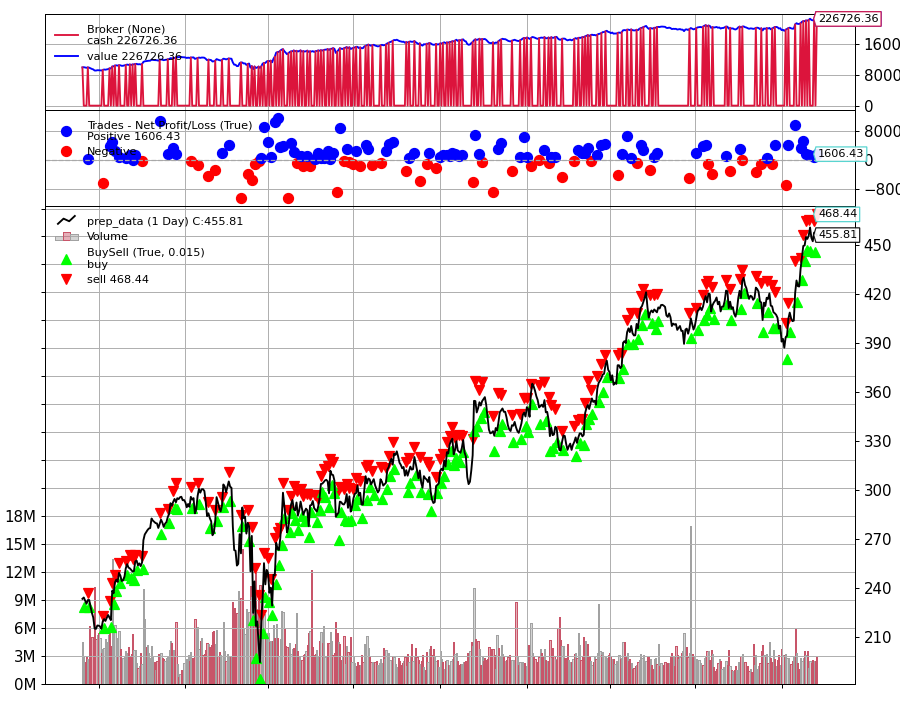

[[<Figure size 720x576 with 4 Axes>]]

In [14]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 12}) 
cerebro_dict['UNH'].plot()